# Read data & prepare for analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as mtick

dt = pd.read_csv('./data/for_prediction.csv')

## Build datasets

For the analysis, we will consider four datasets :
    
    + Dataset #0 : includes ENERGYScore & Energy Mix (i.e. proportions of Steam/Elec/Gas).
    + Dataset #1 : includes ENERGYScore & but not Energy Mix (i.e. proportions of Steam/Elec/Gas).
    + Dataset #2 : doesn't includes ENERGYScore & but includes Energy Mix (i.e. proportions of Steam/Elec/Gas).
    + Dataset #3 : doesn't includes ENERGYScore nor Energy Mix (i.e. proportions of Steam/Elec/Gas).

In [2]:
dt_subset = list()


y_ = 'SiteEnergyUse(kBtu)'
# y_ = 'GHGEmissions(MetricTonsCO2e)'

# Keeping ENERGYScore & Energy mix (props.)
data_I = [y_, 'PrimaryPropertyType',\
        'YearBuilt', 'PropertyGFATotal', 'PropertyGFABuildings_prop', 'dist_to_centroid',\
        'ENERGYSTARScore', 'CouncilDistrictCode', 'Steam_prop', "Electricity_prop", 'Gas_prop']
dt_subset.append(dt[data_I].copy())

# Keeping ENERGYScore & but not Energy mix (props.)
data_II = [y_, 'PrimaryPropertyType',\
        'YearBuilt', 'PropertyGFATotal', 'PropertyGFABuildings_prop', 'dist_to_centroid',\
        'ENERGYSTARScore', 'CouncilDistrictCode']
dt_subset.append(dt[data_II].copy())

# Keeping not ENERGYScore & but Energy mix (props.)
data_III = [y_, 'PrimaryPropertyType',\
        'YearBuilt', 'PropertyGFATotal', 'PropertyGFABuildings_prop', 'dist_to_centroid',\
        'CouncilDistrictCode', 'Steam_prop', "Electricity_prop", 'Gas_prop']
dt_subset.append(dt[data_III].copy())

# Not keeping ENERGYScore nor Energy mix (props.)
data_IV = [y_, 'PrimaryPropertyType',\
        'YearBuilt', 'PropertyGFATotal', 'PropertyGFABuildings_prop', 'dist_to_centroid',\
        'CouncilDistrictCode']
dt_subset.append(dt[data_IV].copy())

In addition to previous operations : 
    
    + Remove row when contain NaN (it's only usefull to remove rows that do not have ENERGYScore)
    + For PrimaryPropertyType : keep only value when at least threshold rows (here, fixed to 10)
    

In [3]:
from collections import Counter

for i in range(len(dt_subset)):
    # Remove data with NaN (for EnergySCORE)
    # np.apply_along_axis(sum, 0, np.array(dt_subset[i].isna()))
    dt_subset[i].dropna(inplace=True) 

    # Filter, Pty Type must have at leat threshold data point
    threshold = 10
    sub_type_lst = [ k for (k,v) in Counter(dt_subset[i]['PrimaryPropertyType']).most_common() if v > threshold ]

    dt_subset[i] = dt_subset[i][dt_subset[i]['PrimaryPropertyType'].isin(sub_type_lst)].copy()

Check datasets sizes : 

In [4]:
# datasets sizes
for i in range(len(dt_subset)):
    print("Dataset #{} shape is {}".format(i, dt_subset[i].shape))

Dataset #0 shape is (1012, 11)
Dataset #1 shape is (1012, 8)
Dataset #2 shape is (1538, 10)
Dataset #3 shape is (1538, 7)


## Get dummies for categorical features

Get dummies for categorical variables, and also keep track of some features before transformation (used later).

In [5]:
# Keep track of primaryPty category (might be used for stratify the data split)
strat = list()
# Keep track of numerical features
num_features = list()
# Keep features names
features_names = list()

for i in range(len(dt_subset)):
    num_features.append([x for x in dt_subset[i].columns if x not in [y_, 'PrimaryPropertyType', 'CouncilDistrictCode']])
    dt_subset[i] = pd.concat( [dt_subset[i],
                               pd.get_dummies(dt_subset[i]['PrimaryPropertyType']),
                               pd.get_dummies(dt_subset[i]['CouncilDistrictCode']) ], axis = 1)

    strat.append(dt_subset[i]['PrimaryPropertyType'])
    dt_subset[i].drop(columns = ['PrimaryPropertyType', 'CouncilDistrictCode'], inplace = True)
    features_names.append(dt_subset[i].columns[1:])

## Quick look at features



For the response variable (EnergyUse) - data are highly skewed ! Let's use the log instead.

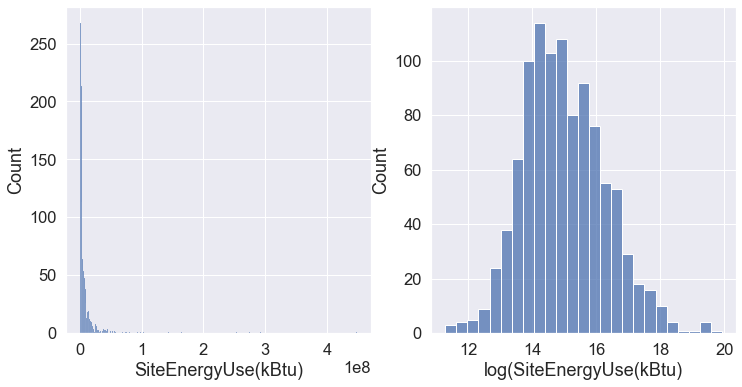

In [6]:
sns.set(rc = {'figure.figsize':(12,6)}, font_scale = 1.5)
fig, ax = plt.subplots(1,2)

p=sns.histplot(dt_subset[0].loc[:,y_], ax = ax[0])
p=sns.histplot(np.log(dt_subset[0].loc[:,y_]), ax = ax[1])
p.set_xlabel('log(SiteEnergyUse(kBtu)');

Far much better ! 

Note : using the log(), the linear models become multiplicatives instead of additives : 

If : $y_i = \sum_{j=1}^{p} X_{ij} \beta_j $, then using the log : $log(y_i) = \sum_{j=1}^{p} X_{ij} \beta_j$ implies : $y_i = e^{\sum_{j=1}^{p} X_{ij} \beta_j} = \prod_{j=1}^{p} e^{X_{ij} \beta_j}$

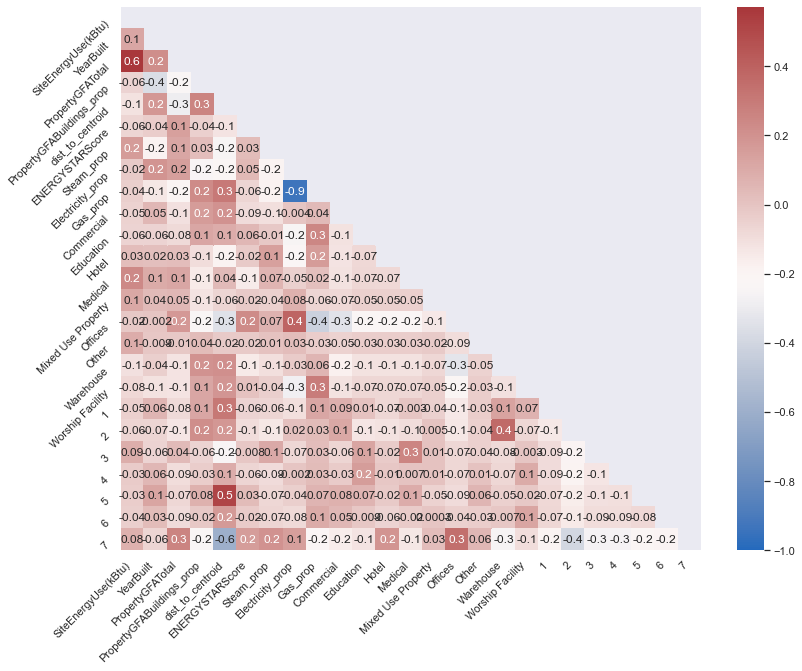

In [7]:
# Look at correlations
i=0
cors = dt_subset[i].corr()
sns.set(rc = {'figure.figsize':(13,10)})

mask = np.zeros_like(cors, dtype=bool)
mask[np.triu_indices_from(mask)] = True

p=sns.heatmap(cors, vmin=-1, mask = mask, cmap=sns.color_palette("vlag", as_cmap=True), annot=True, fmt='.1g')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right');
p.set_yticklabels(p.get_yticklabels(), rotation=45, verticalalignment='top');

# Analysis

Define function for data preparation (i.e. y vs. X, scaling, and split)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(df, target, num_features, strats):
    X = df.drop(columns = [target])
    y = np.log(df[target]) # Using log-transform for y

    ss = StandardScaler()
    X.loc[:,num_features] = ss.fit_transform(X.loc[:,num_features]) # Scale only non-categorical - for easier interpretation
    # X.loc[:,:] = ss.fit_transform(X.loc[:,:]) # Scale all


    return(train_test_split(X, y, train_size = 0.8, stratify = strats))


# TESTS CASES
# which_dataset = 1
# X_train, X_test, y_train, y_test = prepare_data(dt_subset[which_dataset], y_, num_features[which_dataset], strat[which_dataset])

# We also define the number of folds for all CV coming
cv_ = 5

# And the score used in CV approaches
score_ = 'r2'

General function to apply all models, on all datasets 

In [9]:
from sklearn import linear_model as lm
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import model_selection

def run_model(model, X_train, y_train, X_test, y_test, param_grid, cv, score):
    print("Using model : {}".format(model))
    
    gridcv = model_selection.GridSearchCV(
    model, 
    param_grid,     
    n_jobs = 10,
    cv=cv,           
    scoring=score).fit(X_train, y_train)
    
    return(gridcv)

In [10]:
# Models to fit and tested hyperparameters
to_fit = [{'model' : lm.LinearRegression(), 'param_grid' : {}},
          {'model' : KNeighborsRegressor(), 'param_grid' : {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}},
          {'model' : lm.Ridge(),            'param_grid' : {'alpha' : np.logspace(-5, 5, 20)}},
          {'model' : lm.Lasso(max_iter = 15000), 'param_grid' : {'alpha' : np.logspace(-5, 5, 20)}},
          {'model' : KernelRidge(kernel = "poly"), 'param_grid' : {'alpha': np.logspace(-5, 5, 20) , 
                                                                      'coef0':[0.1,0.5,0.8,1,1.2,1.5,1.9,2.5,10],
                                                                      'degree' : [2, 3]}},
          {'model' : KernelRidge(kernel = "rbf"), 'param_grid' : {'alpha': np.logspace(-5, 5, 20) , 
                                                                      'coef0':[0.1,0.5,0.8,1,1.2,1.5,1.9,2.5,10],
                                                                      'degree' : [2, 3]}},
          ### Convergence issur with LinearSVR - but problem is not really linear... 
          {'model' : LinearSVR(max_iter=25000), 'param_grid' : {'C': np.logspace(-3, 3, 7) , 
                                                                  'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'],
                                                                  'epsilon' : [1, 1e1, 1e2, 1e3, 1e4, 1e5]}},
          {'model' : SVR(max_iter=20000, kernel = 'poly'), 'param_grid' :  {'C': np.logspace(-6, 6, 7) ,
                                                                             'epsilon' : [1, 1e1, 1e2, 1e3, 1e4, 1e5],
                                                                             'coef0':[0.1,0.5,0.8,1,1.2,1.5,1.9,2.5,10],
                                                                             'degree' : [1, 2, 3]}},
          {'model' : SVR(max_iter=20000, kernel = 'rbf'), 'param_grid' :  {'C': np.logspace(-6, 6, 7) ,
                                                                             'epsilon' : [1, 1e1, 1e2, 1e3, 1e4, 1e5],
                                                                             'coef0':[0.1,0.5,0.8,1,1.2,1.5,1.9,2.5,10],
                                                                             'degree' : [1, 2, 3]}},
          {'model' : MLPRegressor(max_iter=1000), 'param_grid' :  {'hidden_layer_sizes': [(100,), (100,50), (100,10)],
                                                                   'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                                                                   'solver' : ['adam', 'lbfgs'],
                                                                   'alpha' : [0.0001, 0.001, 0.01]}},
          {'model' : tree.DecisionTreeRegressor(), 'param_grid' :  { 'max_depth': [3,5,7,9],
                                                                       'min_samples_split' : [2, 5, 10],
                                                                       'min_samples_leaf' : [1, 3, 5, 7]}},
          {'model' : RandomForestRegressor(), 'param_grid' :  {'n_estimators': [500, 1000],
                                                                   'max_features': ['auto', 'sqrt'],
                                                                   'max_depth': [3,5,7,9],
                                                                   'bootstrap': [True, False]}},
          {'model' : XGBRegressor(), 'param_grid' : {'learning_rate': [0.01, 0.05, .07],
                                                          'max_depth': [5, 6, 7],
                                                          'min_child_weight': [3,5,7,9],
                                                          'subsample': [0.5, 0.7, 0.9],
                                                          'colsample_bytree': [0.5, 0.7],
                                                          'n_estimators': [500]}}
         ]


In [ ]:
# Just run ONCE
results = pd.DataFrame({'dataset' : pd.Series(dtype='int'),
                        'model':    pd.Series(dtype=object),
                        'best_estimator' : pd.Series(dtype=object),
                        'best_params' : pd.Series(dtype=object),
                        'mean_fit_time' : pd.Series(dtype='float'),
                        'mean_score_time' : pd.Series(dtype='float'),
                        'train_r2' : pd.Series(dtype='float'),
                        'test_r2_mean' : pd.Series(dtype='float'),
                        'test_r2_sd' : pd.Series(dtype='float'),
                        'val_r2' : pd.Series(dtype='float'),
                        })

for dts in range(len(dt_subset)):
    X_train, X_test, y_train, y_test = prepare_data(dt_subset[dts], y_, num_features[dts], strat[dts])
    print("==> With data #{}".format(dts))
    for tf in to_fit:
        gridcv = run_model(tf['model'], X_train, y_train, X_test, y_test, tf['param_grid'], cv_, score_)
        test_scores = pd.DataFrame(gridcv.cv_results_).sort_values('rank_test_score').iloc[0,:]
        dt_to_concat = pd.DataFrame({'dataset': [ dts ],
                                         'model' : [ tf['model'] ],
                                         'best_estimator' : [ gridcv.best_estimator_ ],
                                         'best_params' : [gridcv.best_params_] if (len(gridcv.best_params_) > 0) else [None],
                                         'mean_fit_time' : [ test_scores['mean_fit_time'] ],
                                         'mean_score_time' : [ test_scores['mean_score_time'] ],                                         
                                         'train_r2' : [ gridcv.score(X_train, y_train) ],
                                         'test_r2_mean' : [ test_scores['mean_test_score'] ],
                                         'test_r2_sd' : [ test_scores['std_test_score'] ],
                                         'val_r2' : [ gridcv.score(X_test, y_test) ],
                                        })
        results = pd.concat([results, dt_to_concat], ignore_index=True)

In [11]:
import pickle
with open('Energy_results.pkl', 'wb') as outp:
    pickle.dump(results, outp, pickle.HIGHEST_PROTOCOL)
    
with open('Energy_results.pkl', 'rb') as inp:
    results_nrj = pickle.load(inp)
    
results_nrj['model_str'] = results_nrj['model'].astype('string').apply( lambda x : x[:21]  )

## Model choice & detailled analysis

### Compare overall models performances on the four datasets

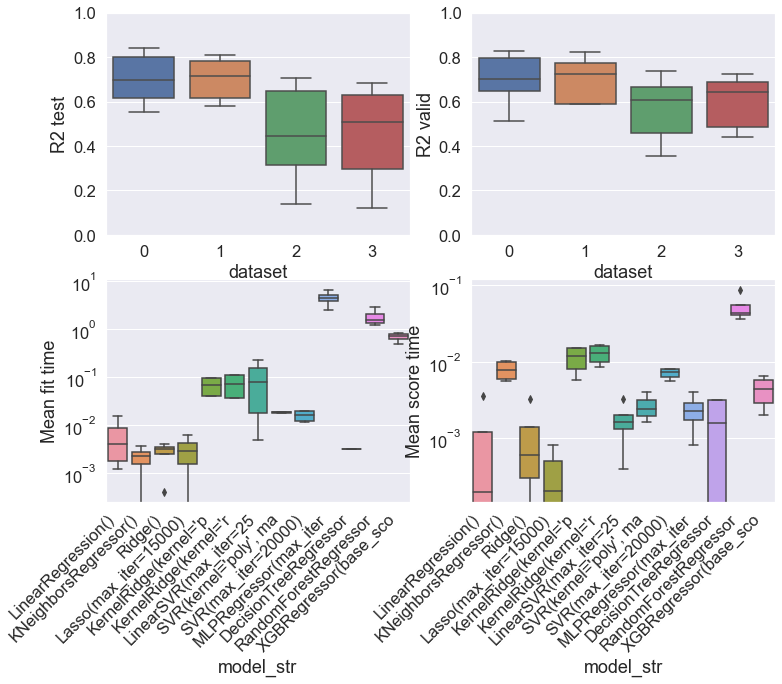

In [13]:
to_plot = results_nrj.loc[:,['dataset', 'model_str', 'test_r2_mean', 'val_r2', 'mean_fit_time', 'mean_score_time']].copy()

sns.set(rc = {'figure.figsize':(12,9)}, font_scale = 1.5)
fig, ax = plt.subplots(2,2)

p=sns.boxplot(x="dataset", y="test_r2_mean", data=to_plot, ax = ax[0,0])
p.set_ylabel('R2 test')
p.set(ylim=(0,1));

p=sns.boxplot(x="dataset", y="val_r2", data=to_plot, ax = ax[0,1])
p.set_ylabel('R2 valid')
p.set(ylim=(0,1));

p=sns.boxplot(x='model_str', y="mean_fit_time", data=to_plot, ax = ax[1,0])
ax[1,0].set(yscale="log")
p.set_ylabel('Mean fit time')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right');

p=sns.boxplot(x="model_str", y="mean_score_time", data=to_plot, ax = ax[1,1])
ax[1,1].set(yscale="log")
p.set_ylabel('Mean score time')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right');



Over all models, on average, considering _ENERGY STAR Score_ increases R2 significantly (compare 0-2 and 1-3) - the effect of ENERGY Mix is almost null (compare e.g., 0-1). Let's see in detail after.

For time spend on fitting : three groups : (i) Linear models + kNN - fit time < $10^{-2}$ s., (ii) kernel LM, SVR, and CART - fit time < $10^{-1}$ s., (iii) MLP, RandomForest & XGBoost - fit time < $10^{1}$ s.

For time spend on prediction/scoring : all are small (i.e. below 0.1 second).


Let's keep only dataset #1 to compare model :

In [15]:
dts = 1 # Best dataset
results_nrj_dt = results_nrj[results_nrj['dataset']==dts]


In [18]:
results_nrj_dt.sort_values(['val_r2'], ascending = False)

,dataset,model,best_estimator,best_params,mean_fit_time,mean_score_time,train_r2,test_r2_mean,test_r2_sd,val_r2,model_str
25,1,"XGBRegressor(base_score=None, booster=None, ca...","XGBRegressor(base_score=0.5, booster='gbtree',...","{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.477278,0.003136,0.994013,0.806330,0.017770,0.821363,XGBRegressor(base_sco
22,1,MLPRegressor(max_iter=1000),"MLPRegressor(activation='tanh', alpha=0.001, h...","{'activation': 'tanh', 'alpha': 0.001, 'hidden...",6.600118,0.004070,0.847264,0.809436,0.020163,0.805837,MLPRegressor(max_iter
24,1,RandomForestRegressor(),"(DecisionTreeRegressor(max_depth=9, max_featur...","{'bootstrap': True, 'max_depth': 9, 'max_featu...",1.189705,0.041086,0.951321,0.786644,0.025701,0.781812,RandomForestRegressor
18,1,KernelRidge(kernel='rbf'),"KernelRidge(alpha=0.04832930238571752, coef0=0...","{'alpha': 0.04832930238571752, 'coef0': 0.1, '...",0.036284,0.008555,0.879750,0.754071,0.064978,0.773458,KernelRidge(kernel='r
17,1,KernelRidge(kernel='poly'),"KernelRidge(alpha=0.1623776739188721, kernel='...","{'alpha': 0.1623776739188721, 'coef0': 1, 'deg...",0.039095,0.005666,0.862931,0.781739,0.020652,0.773453,KernelRidge(kernel='p
23,1,DecisionTreeRegressor(),"DecisionTreeRegressor(max_depth=7, min_samples...","{'max_depth': 7, 'min_samples_leaf': 7, 'min_s...",0.003126,0.003124,0.845783,0.715934,0.023787,0.769229,DecisionTreeRegressor
20,1,"SVR(kernel='poly', max_iter=20000)","SVR(coef0=2.5, epsilon=1, kernel='poly', max_i...","{'C': 1.0, 'coef0': 2.5, 'degree': 3, 'epsilon...",0.018586,0.001618,0.804688,0.734002,0.048244,0.723905,"SVR(kernel='poly', ma"
21,1,SVR(max_iter=20000),"SVR(C=100.0, coef0=0.1, degree=1, epsilon=1, m...","{'C': 100.0, 'coef0': 0.1, 'degree': 1, 'epsil...",0.012170,0.008074,0.797622,0.711116,0.033903,0.679251,SVR(max_iter=20000)
13,1,LinearRegression(),LinearRegression(),None,0.006028,0.000403,0.641481,0.611364,0.033760,0.593259,LinearRegression()
16,1,Lasso(max_iter=15000),"Lasso(alpha=0.004281332398719391, max_iter=15000)",{'alpha': 0.004281332398719391},0.002016,0.000406,0.639092,0.615939,0.030176,0.590918,Lasso(max_iter=15000)


XGBoost is fourth in the list when sorted by Validation R2, take longer to be trained (10x the time for KernelRidge), but is fast for prediction (ca. 1/2 x time for KernelRidge) and have a good R2 score on test datasets (from CV) and low sd. Let keep that one.

### Using best model (better tradeoff)

In [20]:
best_estimator = results_nrj_dt[results_nrj_dt.model_str == 'XGBRegressor(base_sco'].iloc[0,:]['best_estimator']

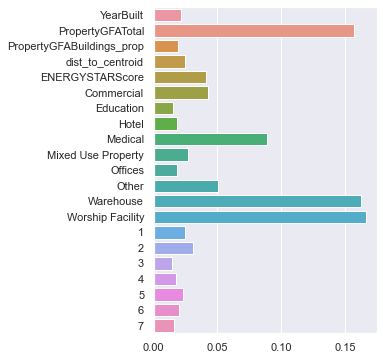

In [21]:
sns.set(rc = {'figure.figsize':(4,6)}, font_scale = 1.)

p=sns.barplot(y = features_names[dts], x=best_estimator.feature_importances_)


  0%|          | 0/203 [00:00<?, ?it/s]

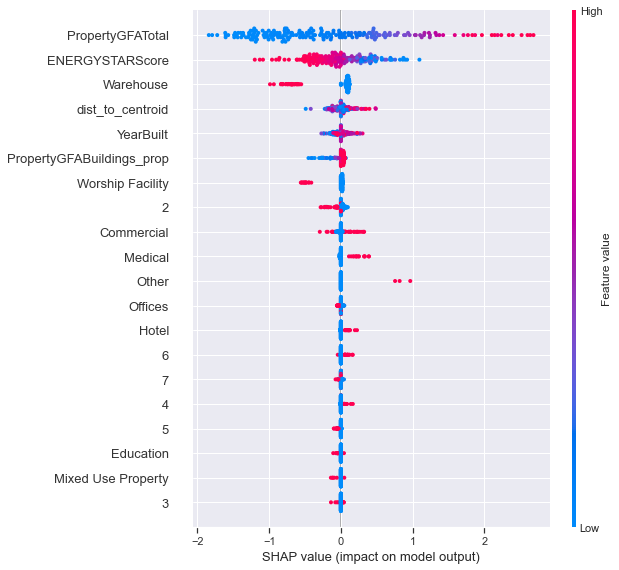

In [22]:
import shap
shap.initjs()

X_train, X_test, y_train, y_test = prepare_data(dt_subset[dts], y_, num_features[dts], strat[dts])
X_train_summary = shap.kmeans(X_train, 100)

ex = shap.KernelExplainer(best_estimator.predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[:,:])

shap.summary_plot(shap_values, X_test.iloc[:,:])

In [23]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_estimator, X_test, y_test,
                            n_repeats=50,
                            random_state=0, scoring = score_)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features_names[dts][i]:<8} : "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

PropertyGFATotal : 1.160 +/- 0.094
ENERGYSTARScore : 0.222 +/- 0.018
Warehouse : 0.100 +/- 0.012
dist_to_centroid : 0.043 +/- 0.007
YearBuilt : 0.032 +/- 0.007
Commercial : 0.022 +/- 0.005
Worship Facility : 0.022 +/- 0.003
PropertyGFABuildings_prop : 0.014 +/- 0.002
Other    : 0.014 +/- 0.004
2        : 0.012 +/- 0.003
Medical  : 0.007 +/- 0.003
6        : 0.002 +/- 0.001
7        : 0.002 +/- 0.001
Mixed Use Property : 0.002 +/- 0.000
3        : 0.001 +/- 0.001
5        : 0.001 +/- 0.000


From these (either importance or Shapley values and permutation importance), the most important feature is _PropertyGFATotal_, followed by _ENERGYSTARScore_. To be noted, from permutation approache, let ENERGYSCORE score reduce by 22 pts the explained variance (see also among dataset comparison above). Also, some other features appear as more useful than ENERGYSCORE for classifying buildings (e.g., building type, medical, warehouse, etc.) - they likely improve point-estimates for such buildings types, more than the ENERGYScore does.  

Council district doen't appear as having strong effect.

#### Posterior features selection 

In [31]:
X_train, X_test, y_train, y_test = prepare_data(dt_subset[dts], y_, num_features[dts], strat[dts])

print("=> Baseline model - all features")
# With best model from above
best_estimator.fit(X_train, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train, y_train),
                                                          best_estimator.score(X_test, y_test)))
# With local hyperparameters tunning
tf = to_fit[12]
gridcv = run_model(tf['model'], X_train, y_train, X_test, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train, y_train),
                                                                  gridcv.best_estimator_.score(X_test, y_test)))

print("=> Without Council Districts")
X_train = X_train.iloc[:,:14]
X_test = X_test.iloc[:,:14]
best_estimator.fit(X_train, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train, y_train),
                                                          best_estimator.score(X_test, y_test)))

gridcv = run_model(tf['model'], X_train, y_train, X_test, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train, y_train),
                                                                  gridcv.best_estimator_.score(X_test, y_test)))


print("=> Without GFA")
X_train_ = X_train.drop('PropertyGFATotal', axis = 1)
X_test_ = X_test.drop('PropertyGFATotal', axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))

gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))

print("=> Without EnergyStarScore")
X_train_ = X_train.drop('ENERGYSTARScore', axis = 1)
X_test_ = X_test.drop('ENERGYSTARScore', axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))

gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))



=> Baseline model - all features
==> (1) Score (R2) : train : 1.00, test : 0.81
Using model : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
==> (2) Score (R2) : train : 0.99, test : 0.81
=> Without Council Districts
==> (1) Score (R2) : train : 0.99, test : 0.79
Using model : XGBRegressor(base_score=None, booster=N

In [32]:

print("=> Without Distance to Centroid")
X_train_ = X_train.drop(['dist_to_centroid'], axis = 1)
X_test_ = X_test.drop(['dist_to_centroid'], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))

gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))


print("=> Without YearBuilt ")
X_train_ = X_train.drop(['YearBuilt'], axis = 1)
X_test_ = X_test.drop(['YearBuilt'], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))

gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))


print("=> Without YearBuilt nor distance to centroid")
X_train_ = X_train.drop(['YearBuilt', 'dist_to_centroid', ], axis = 1)
X_test_ = X_test.drop(['YearBuilt', 'dist_to_centroid'], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))

gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))

print("=> Without Pty Type")
X_train_ = X_train.drop(['Commercial', 'Education', 'Mixed Use Property', 'Offices', 'Other', 'Hotel', 'Medical', 'Warehouse', 'Worship Facility' ], axis = 1)
X_test_ = X_test.drop(['Commercial', 'Education', 'Mixed Use Property', 'Offices', 'Other', 'Hotel', 'Medical', 'Warehouse', 'Worship Facility' ], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))

gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))


print("=> Without YearBuilt nor distance to centroid nor energystar")
X_train_ = X_train.drop(['YearBuilt', 'dist_to_centroid', 'ENERGYSTARScore' ], axis = 1)
X_test_ = X_test.drop(['YearBuilt', 'dist_to_centroid', 'ENERGYSTARScore'], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))
gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))

print("=> Without Pty type, nor yearbuilt nor distance")
X_train_ = X_train.drop(['Commercial', 'Education', 'Mixed Use Property', 'Offices', 'Other', 'Hotel', 'Medical', 'Warehouse', 'Worship Facility','YearBuilt', 'dist_to_centroid' ], axis = 1)
X_test_ = X_test.drop(['Commercial', 'Education', 'Mixed Use Property', 'Offices', 'Other', 'Hotel', 'Medical', 'Warehouse', 'Worship Facility', 'YearBuilt', 'dist_to_centroid' ], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))
gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))

print("=> Without Pty type, nor yearbuilt nor distance nor ENERGY")
X_train_ = X_train.drop(['ENERGYSTARScore', 'Commercial', 'Education', 'Mixed Use Property', 'Offices', 'Other', 'Hotel', 'Medical', 'Warehouse', 'Worship Facility','YearBuilt', 'dist_to_centroid' ], axis = 1)
X_test_ = X_test.drop(['ENERGYSTARScore','Commercial', 'Education', 'Mixed Use Property', 'Offices', 'Other', 'Hotel', 'Medical', 'Warehouse', 'Worship Facility', 'YearBuilt', 'dist_to_centroid' ], axis = 1)
best_estimator.fit(X_train_, y_train)
print("==> (1) Score (R2) : train : {:.2f}, test : {:.2f}".format(best_estimator.score(X_train_, y_train),
                                                          best_estimator.score(X_test_, y_test)))
gridcv = run_model(tf['model'], X_train_, y_train, X_test_, y_test, tf['param_grid'], cv_, score_)
print("==> (2) Score (R2) : train : {:.2f}, test : {:.2f}".format(gridcv.best_estimator_.score(X_train_, y_train),
                                                                  gridcv.best_estimator_.score(X_test_, y_test)))

=> Without Distance to Centroid
==> (1) Score (R2) : train : 0.99, test : 0.82
Using model : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
==> (2) Score (R2) : train : 0.98, test : 0.82
=> Without YearBuilt 
==> (1) Score (R2) : train : 0.99, test : 0.79
Using model : XGBRegressor(base_score=None, booster=None, cal